# Setup

In [5]:
import cv2
import torch
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms
from torch.utils.serialization import load_lua

# Gray Image

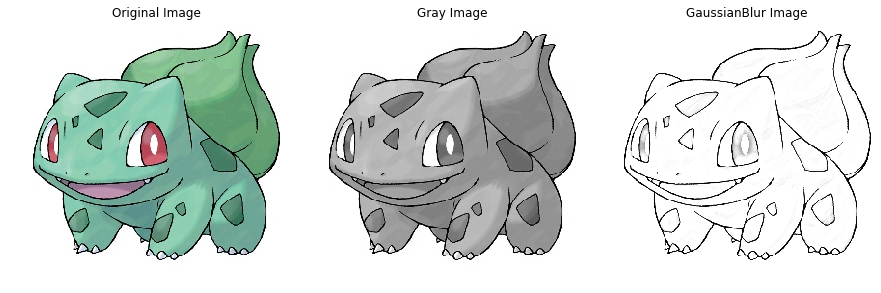

In [3]:
#make gray img
img = cv2.imread('./images/0.jpg')
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# not 연산 반대로
img_invert = cv2.bitwise_not(gray_image)

# 가우시안 블러 적용
# src: 적용 대상,
# ksize: 가우시안 커널 크기. (0, 0)을 지정하면 sigma 값에 의해 자동 결정됨 - 
# 숫자가 작으면 선이 유실되고,
# 숫자가 많으면 선이 너무 찐하게 나와서 적정값이 21
img_smoothing = cv2.GaussianBlur(img_invert, (21, 21), sigmaX=0, sigmaY=0)

# gray_image 에서 255 - img_smoothing를 나누기 연산
final_img = cv2.divide(gray_image, 255 - img_smoothing, scale=256)

cv2.imwrite('./gray.jpg',final_img)

plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.title('Original Image')
plt.axis('off')
plt.imshow(img[:,:,::-1])

plt.subplot(1,3,2)
plt.title('Gray Image')
plt.axis('off')
plt.imshow(gray_image,cmap='gray')

plt.subplot(1,3,3)
plt.title('GaussianBlur Image')
plt.axis('off')
plt.imshow(final_img,cmap='gray')

plt.show()

# Sketch Image

start unsqueeze()
start ReplicationPad2d()
don't use cuda


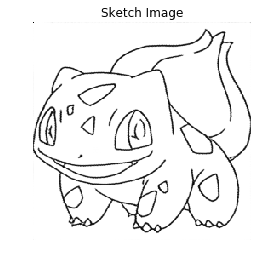

In [6]:
use_cuda = torch.cuda.device_count() > 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cache  = load_lua('./model_gan.t7',long_size=8)
model  = cache.model
immean = cache.mean
imstd  = cache.std
model.evaluate()

data = Image.open('./gray.jpg').convert('L')

w, h = data.size[0], data.size[1]
pw = 8-(w%8) if w%8!=0 else 0
ph = 8-(h%8) if h%8!=0 else 0

print('start unsqueeze()')

data = ((transforms.ToTensor()(data)-immean)/imstd).unsqueeze(0)
if pw != 0 or ph != 0:
    data = torch.nn.ReplicationPad2d( (0,pw,0,ph) )( data ).data

print('start ReplicationPad2d()')
if use_cuda:
    print(' use cuda')
    pred = model.cuda().forward(data.cuda()).float()
else:
    print('don\'t use cuda')
    pred = model.forward(data)

sketch_img = pred[0].squeeze(0).numpy()
plt.title('Sketch Image')
plt.axis('off')
plt.imshow(sketch_img,cmap='gray')